<h1><center> SD701: Prédictions sur des données d'Airbnb en utilisant Spark </center></h1>

<center><b>par Vincent Martinez</b></center>

# Présentation du sujet

L'idée du projet est de voir si les prix ou les notes d'un logement à Paris peut être prédit par des données fournis aux utilisateurs.
Le source de données, les csv résultats et le code est disponible sur mon git à l'adresse suivante:
https://github.com/ms2020bgd/Vincent_Martinez/tree/master/SD701

J'ai choisi d'utiliser une extraction de la base d'Airbnb pour la ville de Paris. Cette base se trouve à l'adresse suivante:
http://insideairbnb.com/paris/#
Seul le fichier "listings" (~250 Mo) servira pour l'analyse. Une copie du fichier a été mis à disposition sur le github et doit être décompressé avant utilisation.
Les autres jeux de données sont une partie ou une consolidation de ce fichier.
Ces données ne proviennent pas d'une base officielle d'Airbnb, mais d'une extraction plus ou moins fidèle des données.

Ce notebook regroupe du post-processing de données. Le notebook spark_in_jupyter m'a servi quand a lui à faire de l'exploration des données.

Le lancement du programme s'effectue par la commande build_and_submit. Il est necessaire de mettre en place les variables necessaire (voir dans le script) et d'avoir decompresser le fichier de données qui se trouve dans le répertoire 'airbnb'. 2 programmes devront être exécutés: Preprocessor qui se chargera de remettre en forme les données sous une forme lisible par spark et un second script AirbnbScoreGuess qui fera des prédictions. On lancera donc "./build_and_submit Preprocessor" ou "./build_and_submit AirbnbScoreGuess".

2 variables dans le fichier AirbnbScoreGuess permette de choisir si on fait une prédiction de prix ou/et de score. Attention aux temps de calcul des grilles qui peut être long.




In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shutil
sns.set()
plt.rcParams['figure.figsize'] = [20, 12]


shutil.unpack_archive("resultats.zip", ".")

# Analyse des données

Mes cibles étaient la prédiction de score et de prix d'un logement à Paris. Je vais donc travailler sur les variables du modèle.

Afin de pouvoir lire correctement les données, j'ai du faire un petit préprocessing. Cela me permet simplement de retirer les guillemets sur-numéraire.
https://github.com/ms2020bgd/Vincent_Martinez/blob/master/SD701/src/main/scala/paristech/Preprocessor.scala


Pour cela, j'ai commencé par regarder les champs de la base, et notament les notes. Il y a 7 champs; 6 entre 1 et 10 en valeur entière, un entre 1 et 100.

In [49]:

df = pd.read_csv("./resultats/data_prepro.csv", delimiter=',')

df = df[df.number_of_reviews!=0]
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3109,https://www.airbnb.com/rooms/3109,20190916233617,2019-09-18,zen and calm,Appartement très calme de 50M2 Utilisation de ...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14 Good restaura...,none,Good restaurants very close the Montparnasse S...,...,f,f,flexible,f,f,1,1,0,0,0.24
1,5396,https://www.airbnb.com/rooms/5396,20190916233617,2019-09-18,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","Small, well appointed studio apartment at the ...","Cozy, well-appointed and graciously designed s...",none,"You are within walking distance to the Louvre,...",...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,1.51
2,7397,https://www.airbnb.com/rooms/7397,20190916233617,2019-09-17,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !",PLEASE ASK ME BEFORE TO MAKE A REQUEST !!! No ...,"VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...",none,NaN,...,f,f,moderate,f,f,1,1,0,0,2.45
3,7964,https://www.airbnb.com/rooms/7964,20190916233617,2019-09-18,Large & sunny flat with balcony !,Very large & nice apartment all for you! - Su...,hello ! We have a great 75 square meter apartm...,Very large & nice apartment all for you! - Su...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.05
4,8522,https://www.airbnb.com/rooms/8522,20190916233617,2019-09-18,GREAT FLAT w/ CITY VIEW,NaN,Really nice flat located in the 20th district ...,Really nice flat located in the 20th district ...,none,NaN,...,f,f,moderate,f,f,1,1,0,0,0.01


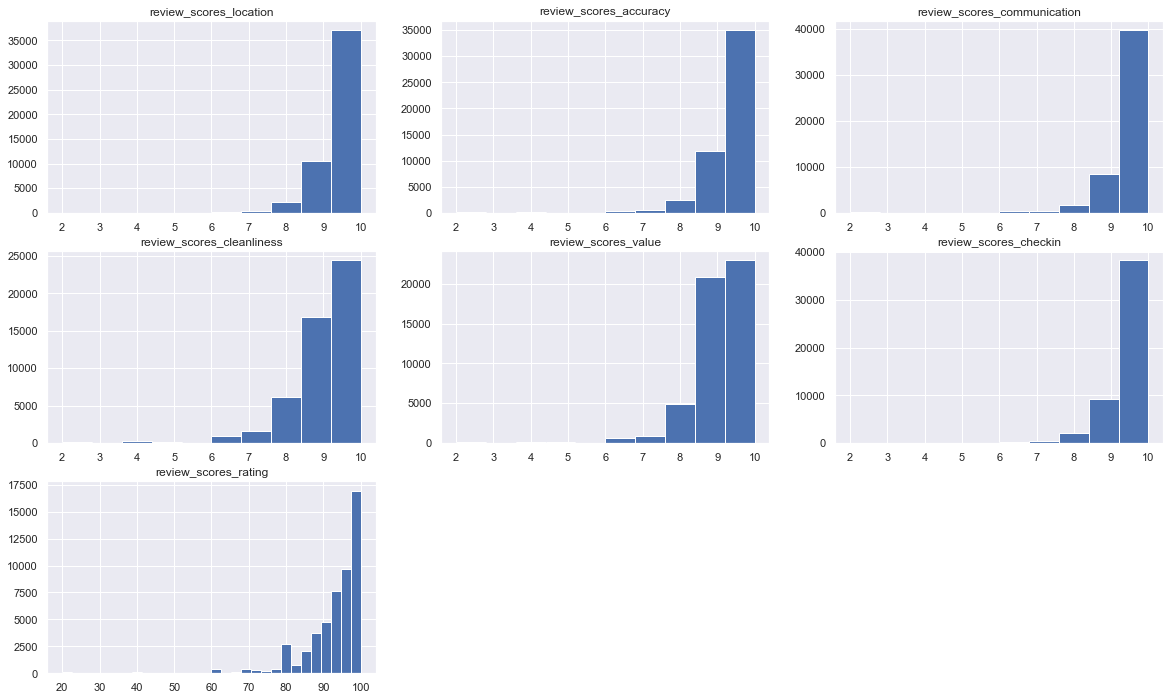

In [50]:
df_score = df[["review_scores_location", "review_scores_accuracy","review_scores_communication","review_scores_cleanliness","review_scores_value","review_scores_checkin","review_scores_rating"]]

df_score = df_score.dropna() # On retire toutes les valeurs nan. Les scores sont homogènes

for i,c in enumerate(df_score.columns):
    plt.subplot(3, 3, i+1)
    if c == "review_scores_rating":
        plt.hist(df_score[c], bins=30)
    else:
        plt.hist(df_score[c], bins=10)
    plt.title(c)
plt.show()

    
    


Afin de lisser les valeurs, j'ai calculé une valeur moyenne de l'ensemble des scores.
Les valeurs de scores nulles sont retirés du dataset afin de garder une moyenne homogène.


92.71428571428571


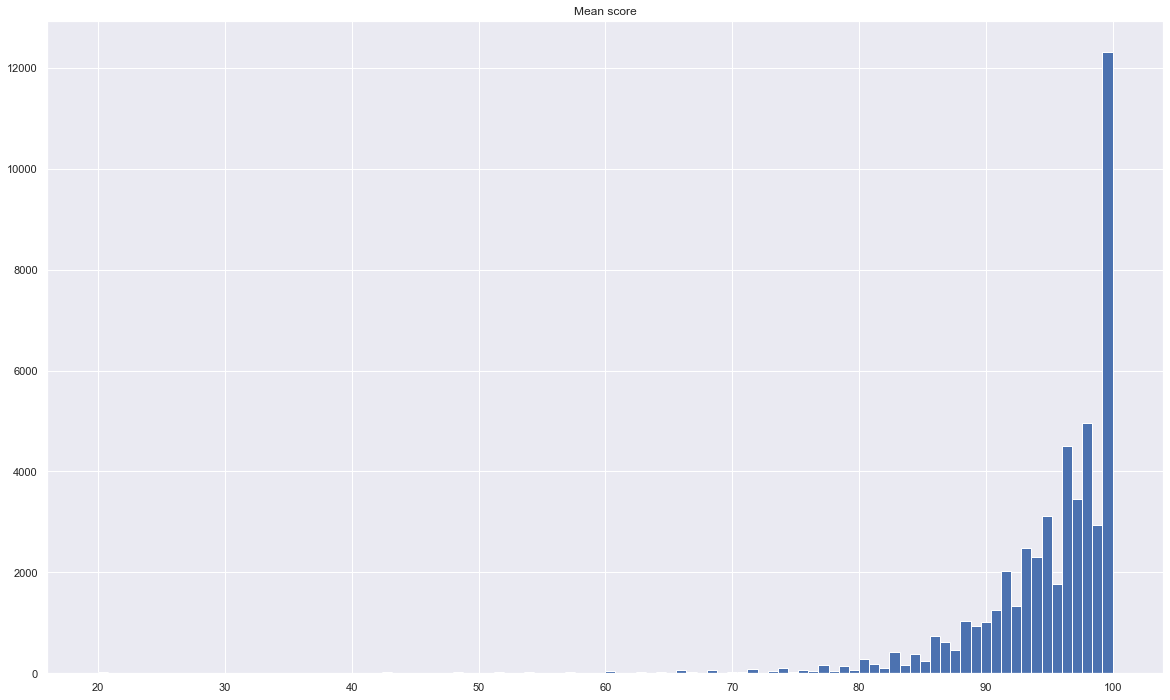

In [32]:
df = df.dropna(subset=df_score.columns)


df["Mean Score"] = 10*(df["review_scores_rating"]/10+df["review_scores_location"]+ \
                             df["review_scores_accuracy"] + df["review_scores_communication"]+df["review_scores_cleanliness"] +df["review_scores_value"] +\
                             df["review_scores_checkin"])/7.0


plt.hist(df["Mean Score"], bins=100)
plt.title("Mean score")

q95 = np.percentile(df["Mean Score"], 25)
print(q95)

Pour faire la prédiction sur les prix, j'ai regardé les colonnes de prix par semaine. C'est une donnée facilement calculable à partir d'un prix journalier si la donnée n'existe pas.


In [33]:
df["price"] = df["price"].str.replace("$","")
df["price"] = df["price"].str.replace(",","")
df.price = pd.to_numeric(df.price)
df.weekly_price = pd.to_numeric(df.weekly_price.str.replace("$","").str.replace(",",""))
mask = df.weekly_price.isnull()
df.loc[mask, "weekly_price"] = df[mask].price*7

Text(0.5, 1.0, 'Histogramme de répartition des prix')

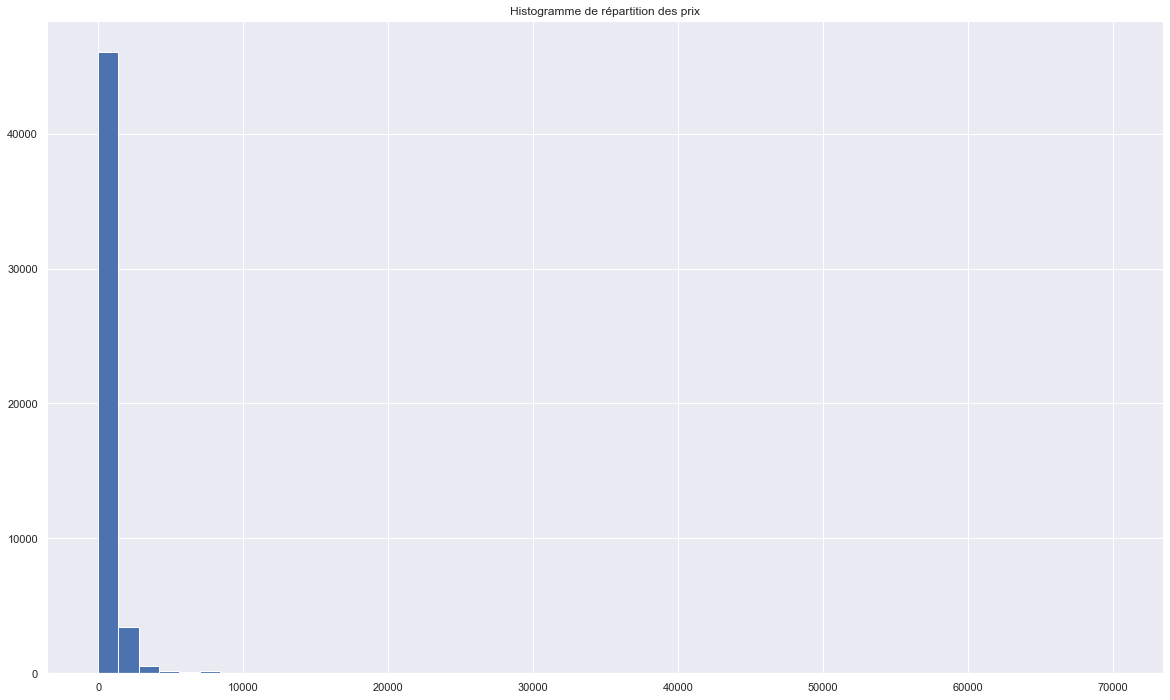

In [34]:
plt.hist(df["weekly_price"] , bins=50, density=False)
plt.title("Histogramme de répartition des prix")

On voit clairement un problème de distribution de valeur. Il exite des valeurs hautes qui pose un gros problème.
On va donc faire un crop des valeurs et on va garder les quantiles 5% et 95%.


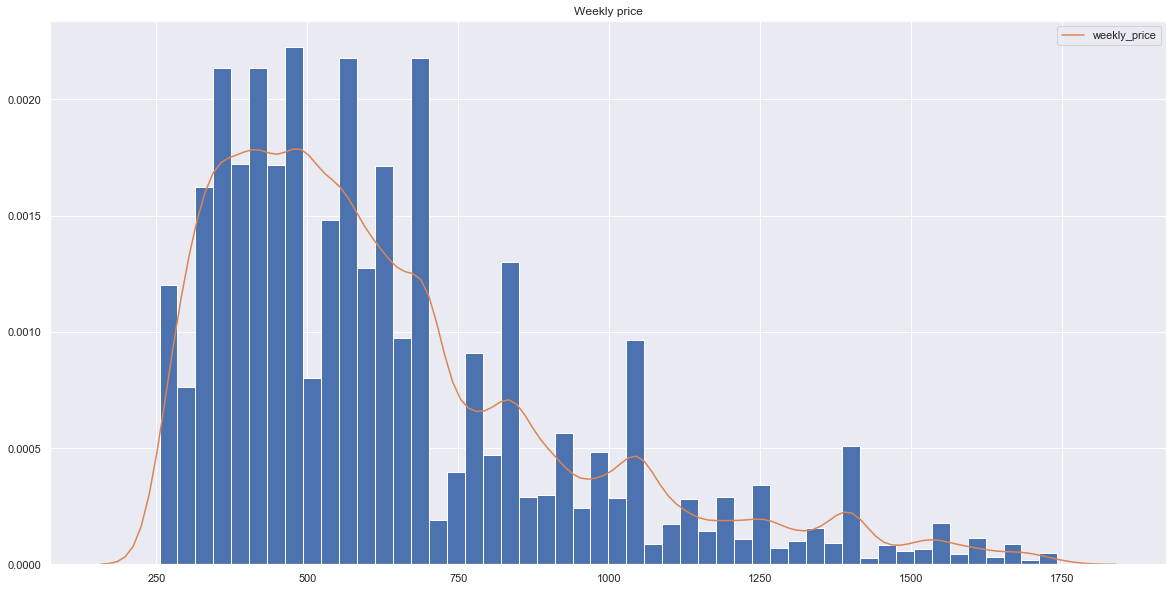

In [35]:


q5 = df["weekly_price"].quantile(0.05)
q95 = df["weekly_price"].quantile(0.95)
df = df[(df.weekly_price > q5) &(df.weekly_price < q95) ]
plt.rcParams['figure.figsize'] = [20, 10]

plt.hist(df["weekly_price"] , bins=50, density=True)
plt.title("Weekly price")
sns.kdeplot(df["weekly_price"] )
plt.show()

Apres ce netoyage, nous avons les scores comme suivants:

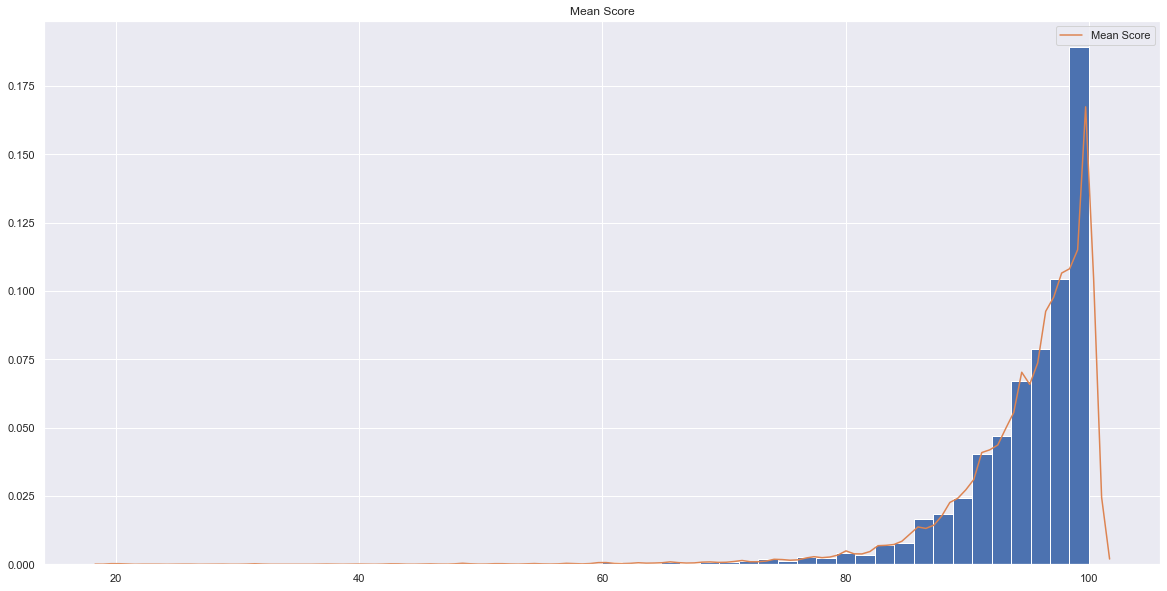

In [36]:
plt.hist(df["Mean Score"] , bins=50, density=True)
plt.title("Mean Score")
sns.kdeplot(df["Mean Score"] )

Pour les autres variables du modèle, nous utiliserons les champs:
    - "accommodates", "bathrooms", "guests_included", "bedrooms", "beds", "number_of_reviews","cleaning_fee" comme variables directes
    - "property_type", "room_type", "neighbourhood" en variables catégorielles. Elles sont remises sous forme d'un ensemble de colonne correspondant à chacune des catégories 
    - "amenities" comme variables catégorielles. La récupération de ces valeurs a necessité la création de fonction spécifique (voir le code scala)
    - Une concatenation de l'ensemble des champs texte de la base ("name", "summary", "space", "description", "neighborhood_overview") pour utilisation d'une méthode de parsing type TF-IDF. Les "stop words" Anglais et Francais ont été supprimés 
    - Les coordonnées exactent des logements (latitude, longitude).
    
 Nous analysons quelques variables directes du modèle via une matrice de corrélation.

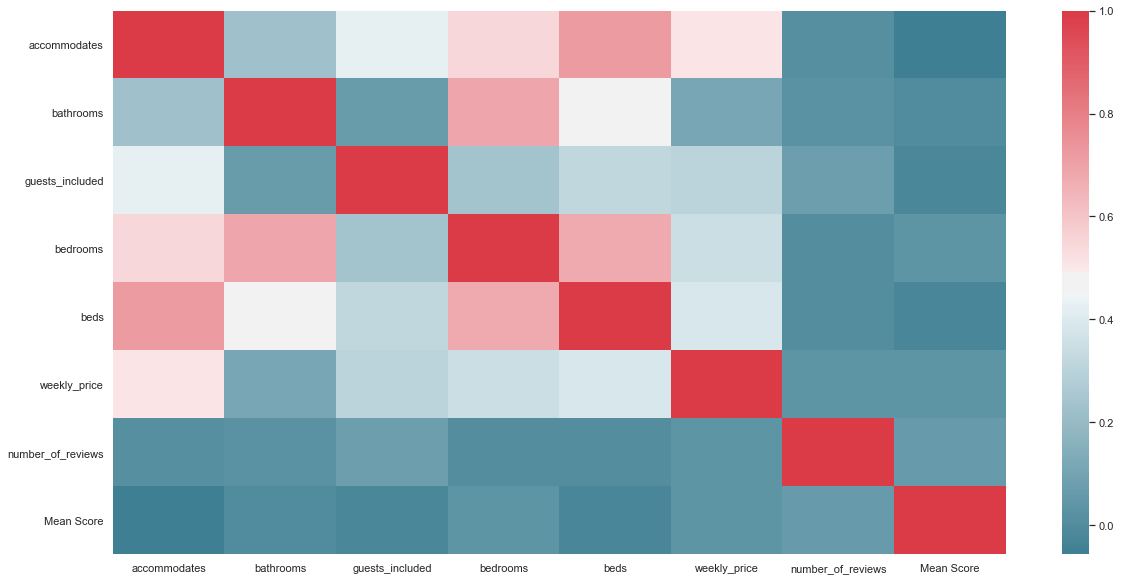

In [37]:
df2 = df[["accommodates", 
    "bathrooms", "guests_included", "bedrooms", "beds", 
    "weekly_price",
    "number_of_reviews",
    "cleaning_fee", "Mean Score"]]

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df2.corr(), cmap=cmap)

Nous filtrons aussi nos données sur les données qui ont au moins une revue. Le nombre de reviewer n'ai par contre pas utilisé lors de nos regressions.

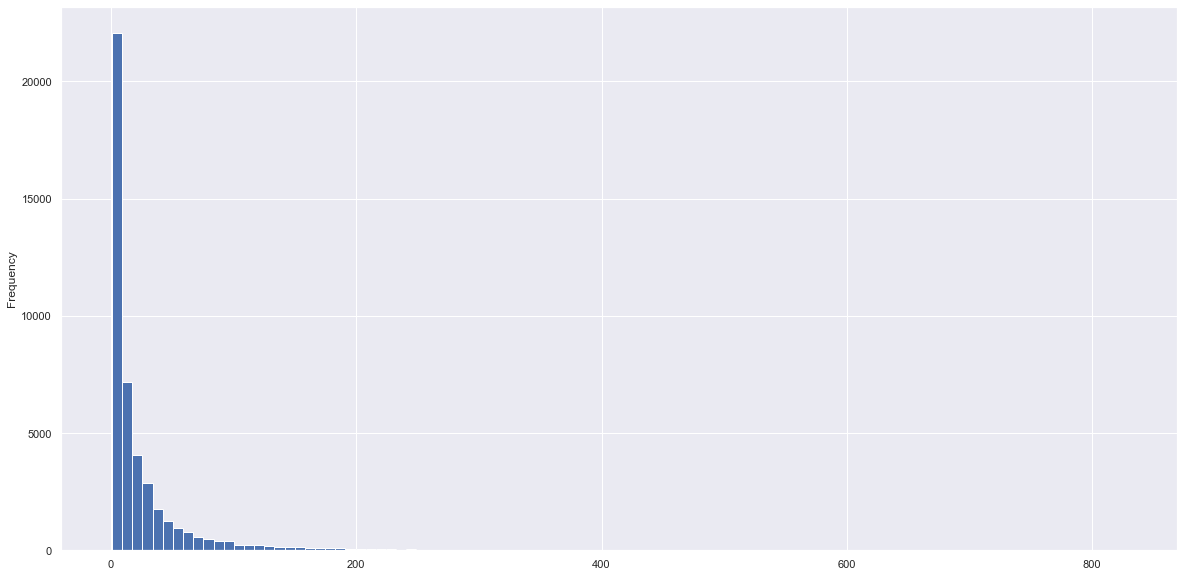

In [38]:
df2.number_of_reviews[df2.number_of_reviews!=0].plot(kind="hist" ,bins=100)

# Prédiction de modèle

Le code source des modèles est disponible sur github: https://github.com/ms2020bgd/Vincent_Martinez/blob/master/SD701/src/main/scala/paristech/AirbnbScoreGuess.scala

## Prédiction du score

Ma première idée est de faire de la prédiction de score par rapport aux caractéristiques d'un logement. Pour faire cette prédiction, j'utilise les variables à ma disposition, excepté le prix et le nombre de revues.

### Modèle linéaire

Pour ma premère prédiction, j'utilse un modèle de regression linéaire.
J'obtiens des performances que je trouve d'abord honorable: mon RMSE est de 6.131
Je lance une grille pour cette prédiction, mon RMSE reste à 6.16.

            Values      Predict       residu
count  4739.000000  4739.000000  4739.000000
mean     94.614536    94.702728     0.088192
std       6.429250     2.010433     6.167244
min      20.000000    86.609569   -11.336213
25%      92.571429    93.423878    -3.610483
50%      96.285714    94.759411    -1.278285
75%      98.571429    96.073504     2.127189
max     100.000000   101.037741    73.813967
6.167224082217708


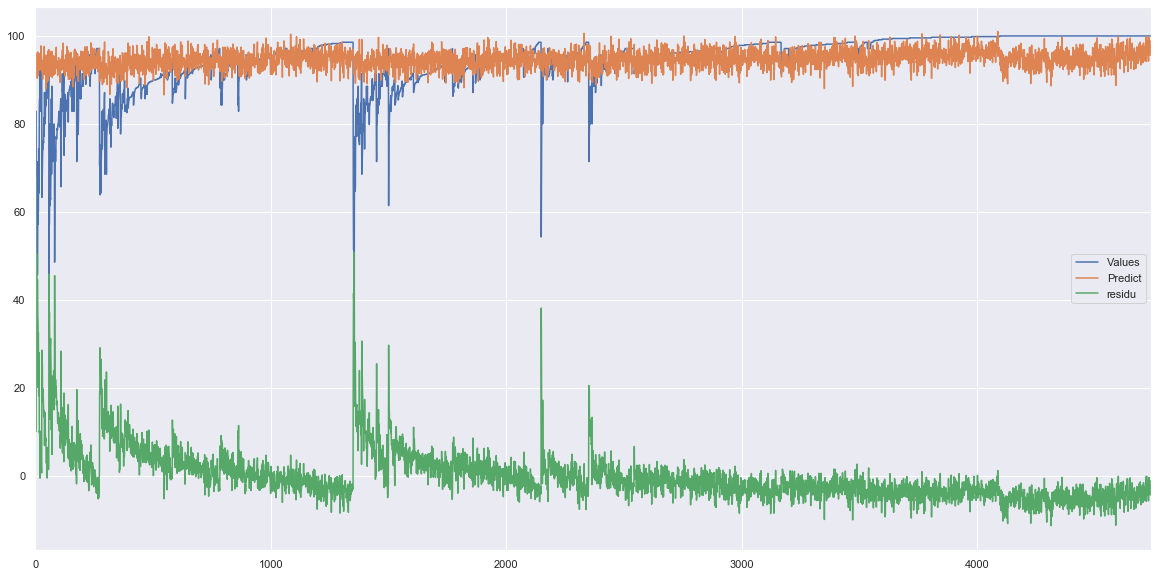

In [39]:
result = pd.read_csv("./resultats/lr_mean_score.csv", delimiter=',', header=None,names=["Values","Predict"])
result["residu"] = result.Predict - result.Values
print(result.describe())
print(np.sqrt(np.mean(result.residu**2)))

result.plot()

En regardant la forme de la courbe de prédiction, on s'apperçoit que la prédiction ne prédit que des valeurs proches de la moyenne. La moyenne de mes valeurs prédites est proche de celle des valeurs à prédire mais je n'ai pas la variation. Mon écart-type est à 2 une valeur minimale proche à 86 au lieu des 20 pour les données de tests.
J'ai donc essayer ensuite une approche non linéaire pour résoudre ce problème.


### Régression non linéaire.

J'ai choisi un random forest comme algorithme de résolution non linéaire. J'ai fais tourner l'algorithme, avec les valeurs par défaut et en ajoutant une grille. J'obtiens les résultats de RMSE 6.24 initialement et 6.16 apres la grille.

            Values      Predict       residu
count  4739.000000  4739.000000  4739.000000
mean     94.614536    94.670143     0.055607
std       6.429250     1.588122     6.160416
min      20.000000    81.028121   -18.971879
25%      92.571429    93.948401    -3.656583
50%      96.285714    95.013232    -1.441190
75%      98.571429    95.730203     2.074335
max     100.000000    97.586606    74.560446
6.160016621320403


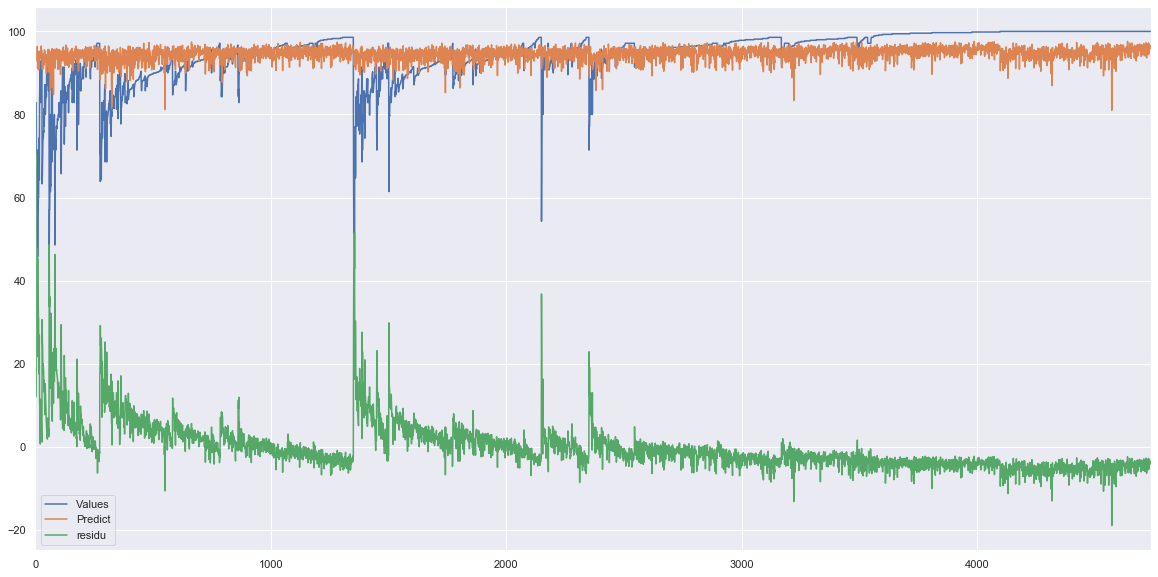

In [41]:
result = pd.read_csv("./resultats/rf_mean_score.csv", delimiter=',', header=None,names=["Values","Predict"])
result["residu"] = result.Predict - result.Values
print(result.describe())
print(np.sqrt(np.mean(result.residu**2)))

result.plot()

L'analyse est la même que pour le modèle linéaire. La prédiction ne prédit presque la moyenne et n'arrive pas à récupérer la variation des valeurs.


### Réintégration du prix dans la prédiction

Afin d'essayer d'avoir un modèle plus prédictif, j'ai remis le prix comme variable du modèle. 


            Values      Predict       residu
count  4740.000000  4740.000000  4740.000000
mean     80.929928    81.053683     0.123755
std       5.540074     1.256376     5.274140
min      17.142857    75.425904    -9.054127
25%      79.000000    80.319765    -3.144803
50%      82.142857    81.163728    -1.003792
75%      84.857143    81.939178     1.777273
max      85.714286    84.789758    63.512953
5.27503513532674


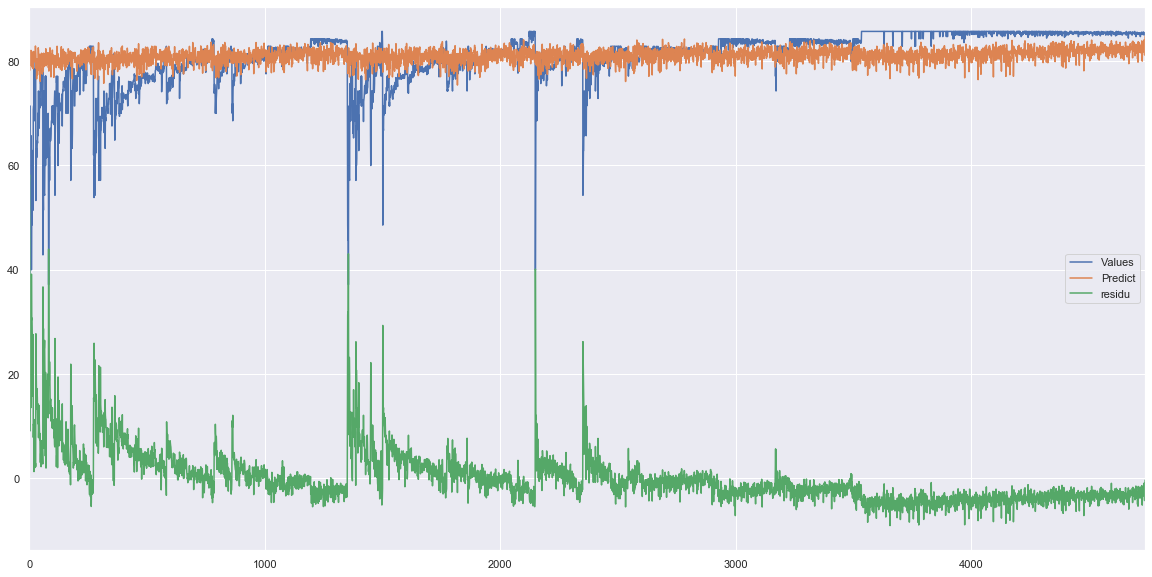

In [42]:
result = pd.read_csv("./resultats/rf_mean_score_with_price.csv", delimiter=',', header=None,names=["Values","Predict"])
result["residu"] = result.Predict - result.Values
print(result.describe())
print(np.sqrt(np.mean(result.residu**2)))

result.plot()

Comme pour les autres modèles, le prix ne semble pas être une variable très influente du modèle. On a une amélioration des performances mais la grande tendance reste des prédictions proche de la moyenne.


### Méthode de classification
Pour essayer d'avoir une prédiction plus juste, j'ai essayé de mettre en place une méthode de classification des valeurs. L'idée est de faire la classification de valeurs par plage; les valeurs proches de 100 étant les plus importantes (voir le graphique du chapitre d'analyse).

J'ai créé 5 catégories: score [99:100], entre [97.5 : 99],  [95 : 97,5], [90 : 95], [75 : 90] et [0: 75]
J'ai utilisé une forêt aléatoire pour faire cette analyse.
Les résultats sont les suivants:

F1 precision = 0.204
Recall = 0.305
Precision = 0.285

|score_cat|score_cat_prect|count|
|---------|---------------|-----|
|        4|            3.0|  401|
|        3|            0.0|  540|
|        1|            0.0|  437|
|        4|            0.0|  223|
|        2|            0.0|  513|
|        3|            3.0|  674|
|        4|            4.0|    1|
|        5|            3.0|   61|
|        2|            3.0|  433|
|        5|            0.0|   20|
|        0|            0.0|  770|
|        1|            3.0|  263|
|        0|            3.0|  403|

En clair, la forêt n'a pas du tout réussi à récuperer des variables explicatrices du système!

### Conclusion

La prédiction de score ne peut donc pas être faite avec les valeurs du modèle. En effet, cela s'explique bien: on met un bon score quand on a eu un bien avec un bon rapport qualité/prix, conforme à nos attentes et avec un bon 'feeling' avec le loueur du logement.

Comme la prédiction de score n'est pas pertinente, j'ai fais ensuite un essai sur de la prédiction de prix par rapport aux caractéristiques des logements.




## Prédiction du prix

Toutes les variables expectées celles liées au score seront utilisées dans ce modèle.
Comme pour la prédiction de score, j'ai fais une approche linéaire et non linéraire.


### Régression linéaire

J'obtiens les résulats suivant pour la regression linéaire:
RMSE: 199.43
Root Mean Squared Error of Grid= 196.25
Les valeurs des paramètres pour ce modèle sont les suivants:
{
	linReg_c4af2efaf1e6-elasticNetParam: 0.01,
	linReg_c4af2efaf1e6-regParam: 0.1,
	cntVec_f7faaf479a2a-vocabSize: 50
}


            Values      Predict       residu
count  4739.000000  4739.000000  4739.000000
mean    619.701625   620.493897     0.792272
std     305.304728   234.447547   196.273544
min      63.000000    -5.685887 -1042.387012
25%     406.000000   450.800202   -87.239449
50%     560.000000   594.516932    23.577780
75%     770.000000   770.582083   120.923414
max    1743.000000  1759.606360   779.606360
196.25443394128058


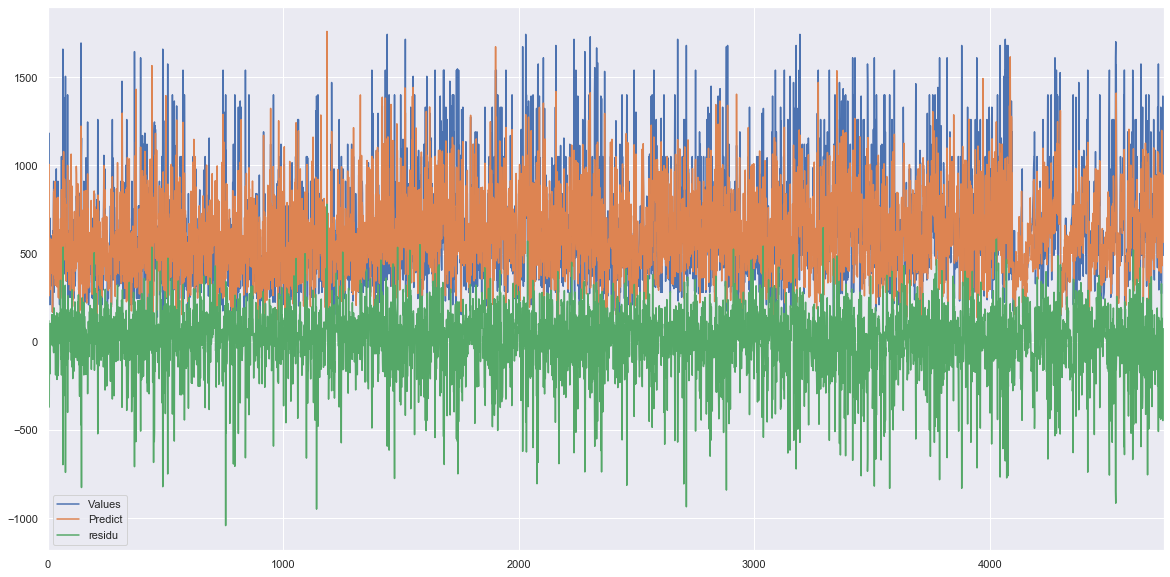

In [43]:
result = pd.read_csv("./resultats/lr_weekly_price.csv", delimiter=',', header=None,names=["Values","Predict"])
result["residu"] = result.Predict - result.Values
print(result.describe())
print(np.sqrt(np.mean(result.residu**2)))

result.plot()

### Régression non linéaire
J'ai aussi fais un essai avec une regression non linéaire. Ce modèle n'a pas été aussi performant initilialement que la regression linéaire mais s'en rapproche avec une grille:

RMSE: 223.09
Root Mean Squared Error of Grid = 197.178
Les valeurs des paramètres pour ce modèle sont les suivants:
{
	rfr_62752fd424e6-maxDepth: 2,
	rfr_62752fd424e6-numTrees: 50,
	cntVec_f7faaf479a2a-vocabSize: 50
}

            Values      Predict       residu
count  4739.000000  4739.000000  4739.000000
mean    619.701625   622.029412     2.327787
std     305.304728   194.237921   211.127855
min      63.000000   288.888128  -976.053780
25%     406.000000   478.022098   -88.085201
50%     560.000000   579.128235    43.769695
75%     770.000000   732.392367   134.872634
max    1743.000000  1333.194426   678.465339
211.118411824274


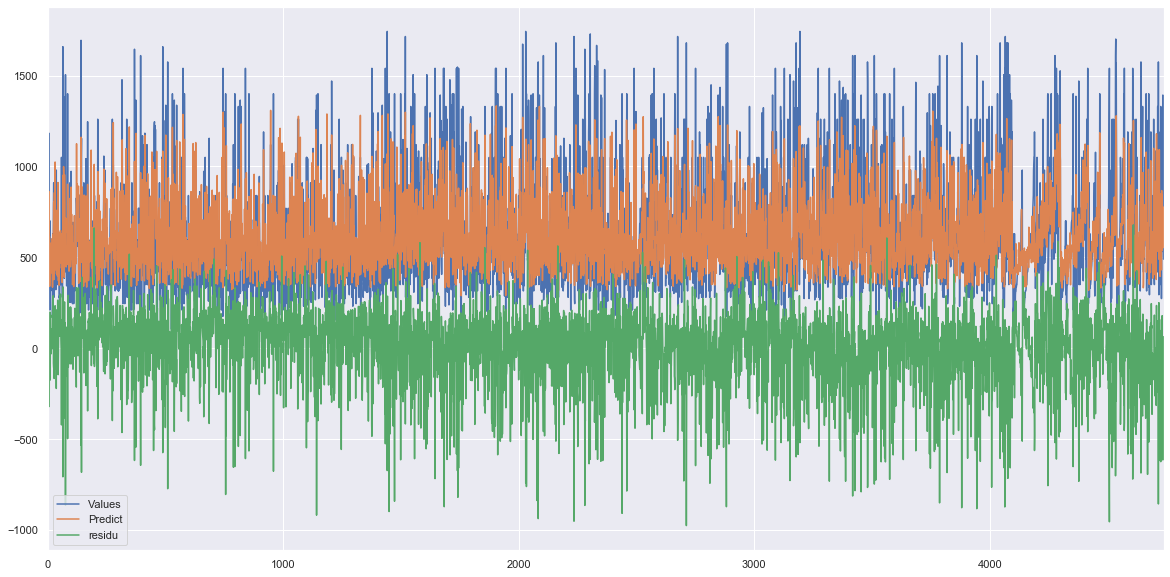

In [44]:
result = pd.read_csv("./resultats/rf_weekly_price.csv", delimiter=',', header=None,names=["Values","Predict"])
result["residu"] = result.Predict - result.Values
print(result.describe())
print(np.sqrt(np.mean(result.residu**2)))

result.plot()

### Ajout de la variable "score"
Dans le cadre de la prédiction du modèle de score, nous avons vu que le prix n'a pas d'influence sur la prédiction du score. Est-ce le cas dans le modèle du prix? Est ce que le score influe sur le prix?

            Values      Predict       residu
count  4740.000000  4740.000000  4740.000000
mean    620.547046   619.852249    -0.694797
std     305.217608   233.287057   198.741941
min      63.000000   -31.508353  -915.021022
25%     404.250000   447.390557   -94.696466
50%     560.000000   595.610285    23.144020
75%     770.000000   767.016050   120.827510
max    1715.000000  1805.227017   602.567294
198.72218973716062


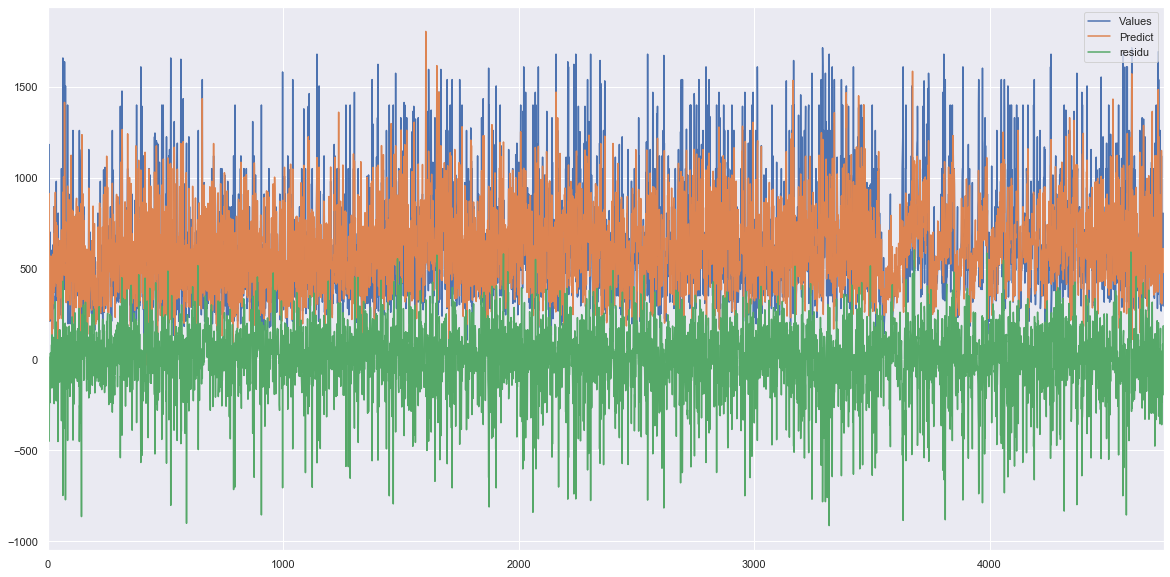

In [45]:
result = pd.read_csv("./resultats/rf_weekly_price_with_score.csv", delimiter=',', header=None,names=["Values","Predict"])
result["residu"] = result.Predict - result.Values
print(result.describe())
print(np.sqrt(np.mean(result.residu**2)))

result.plot()



### Conclusion
Les modèles de prédiction de prix sont assez performant. La variation des prix est bien prise en compte; surtout pour le modèle linéaire. Par contre, il faudrait voir pour faire un modèle contraint afin de ne pas pouvoir prédire des valeurs négatives.

## Conclusion générale

Lors de cet exercice, je n'ai donc pas atteins l'objectif que je m'etais fixé, à savoir la prédiction de score par rapport aux données présentes dans le modèle. Il semblerait que cette notion ne soit donc pas prévisible par un modèle classique. Il faudrait voir si la prédiction est possible en utilisant d'autres données (analyses des photos, textes des revues des utilisateurs...).

J'ai par contre réussit à avoir un modèle de prédiction de prix mais il reste perfectible. Aujourd'hui, je suis à 196 € d'erreur moyenne sur ma prédiction, avec une forte volatilité de prédiction sur les prix les plus élevés. Il faudrait aller plus en avant dans l'analyse et voir si un autre modèle pourrait être mis en place pour résoudre ce problème.

Enfin, j'ai pu constaté que les variables de score et de prix ne sont finalement pas corrélé: un prix élevé n'implique par forcement un bon score et inversement.